In [6]:
from Bio.Seq import Seq

import dataclasses
import pandas as pd
import gzip
import matplotlib as plt
from collections import Counter
import numpy as np
from joblib import Parallel, delayed
import time
import gc
from functools import reduce
import operator
import itertools
import multiprocessing
from multiprocessing import Manager

def MutationInfo(seq1, seq2, delimiter="+"):
    differences = [i for i in range(len(seq1)) if seq1[i] != seq2[i]]
    out = ""
    if len(differences) == 0:
        return "WT"
    for dd in differences:
        out = out + seq1[int(dd)] + str(dd+1) + seq2[int(dd)]
        if len(differences) > 1:
            out = out + delimiter

    if len(differences) > 1:
        return out[:-1]
    return out



def findOffset(primer, seq):
    # Find the starting index of the last occurrence of substring1 in string2
    start_index = seq.rfind(primer)
    
    if start_index == -1:
        # substring1 is not found in string2
        return -1
    
    # Compute the index of the last character of substring1 within string2
    last_char_index = start_index + len(primer)
    return last_char_index


def NumberMutations(seq1,seq2):
    return sum(1 for a, b in zip(seq1, seq2) if a != b)

def translateDNA(ntSeq):	
    dna_seq = Seq(ntSeq)
    return str(dna_seq.translate())


def flattenList(lst):
    return reduce(operator.add, lst)

#templateSeq needs to be nucleotide, not protein
def readNGSfiles(file, templateSeq, fwdPrimer,nworkers=12):
    
    with open(file) as f:
        lines = f.readlines()
    manager = Manager()
    reads = manager.list(lines[1::4]) 
    # Find the offset of the primer in the first sequence line
    offset = findOffset(fwdPrimer, lines[1])
    if offset == -1:
        raise ValueError("Forward primer not found in the sequence")
    refAAseq = translateDNA(templateSeq)

    print('number of lines: ' + str(len(lines)) + ' and reads: ' + str(len(reads)) + '\n')
    del lines
    gc.collect()
    
    if nworkers==0:
        results = readLines(reads,templateSeq,offset,0,len(reads),file)    
    else:
        nitems = int(len(reads)/(nworkers))
        StartNdx = list(range(0,len(reads),nitems))
        startTime = time.time()
        results = Parallel(nworkers)(delayed(readLines)(reads,templateSeq,offset,indices,nitems,file) for indices in StartNdx)
        endTime = time.time()
        print('time to process file: '+str(endTime-startTime))

    variants = []
    protseq = []
    filename = []
    fileline = []
    NTmutinfo = []
    numNTmuts = []
    AAmutinfo = []
    numAAmuts = []
    
    if nworkers == 0:
        variants = results[0]
        protseq = results[1]
        filename = results[2]
        fileline = results[3]
        NTmutinfo = results[4]
        numNTmuts = results[5]
        AAmutinfo = results[6]
        numAAmuts = results[7]
    else:

        for i in range(0,nworkers):
             variants = [*variants, *results[i][0]]
             protseq = [*protseq, *results[i][1]]
             filename = [*filename, *results[i][2]]
             fileline = [*fileline, *results[i][3]]
             NTmutinfo = [*NTmutinfo, *results[i][4]]
             numNTmuts = [*numNTmuts, *results[i][5]]
             AAmutinfo = [*AAmutinfo, *results[i][6]]
             numAAmuts = [*numAAmuts, *results[i][7]]
    
    df = {
          'variants': pd.Series(variants),
          'protseq': pd.Series(protseq),
          'filename': pd.Series(filename),       
          'fileline': pd.Series(fileline),
          'NTmutinfo': pd.Series(NTmutinfo),
          'numNTmuts': pd.Series(numNTmuts),
          'AAmutinfo': pd.Series(AAmutinfo),
          'numAAmuts': pd.Series(numAAmuts)
    }

    return pd.DataFrame(df)
	

#if using parallel, should use existing protein sequences
def readLines(lines,templateSeq,offset,indexStart,nitems,filelabel):

    readlen = len(templateSeq)  
    print('readlength is: ' + str(readlen))
    print('worker reading from: '+str(indexStart) + ' to ' + str(indexStart+nitems) + '\n')  
    variants = []
    protseq = []
    fileName = []
    fileLine = []
    NTmutinfo = []
    numNTmuts = []
    AAmutinfo = []
    numAAmuts = []
    refAAseq = translateDNA(templateSeq)
    endndx = indexStart+nitems
    if endndx > len(lines):
        endndx = len(lines)
    for i in range(indexStart, endndx):  # Get sequences and counts
        seq_i = lines[i].rstrip()[offset:(offset + readlen)]
        if len(seq_i) == 498: #check that read is not truncated

            aaSeq = translateDNA(seq_i)
            AA = MutationInfo(aaSeq,refAAseq)
            NT = MutationInfo(seq_i,templateSeq)
            variants.append(seq_i)
            protseq.append(aaSeq)
            fileName.append(filelabel)
            fileLine.append(i)
            NTmutinfo.append(NT)
            AAmutinfo.append(AA)
            numNTmuts.append(NumberMutations(seq_i,templateSeq))
            numAAmuts.append(NumberMutations(aaSeq,refAAseq))

    return [variants,protseq,fileName,fileLine,NTmutinfo,numNTmuts,AAmutinfo,numAAmuts]
  





In [7]:
def filterByCounts(df,minvalue = 100,nucleotide=True):
    c = None
    if nucleotide:
        c = df['variants'].value_counts()
        df['counts'] = df['variants'].map(c) #adds a new column called 'counts'
    else:
        c = df['protseq'].value_counts()
        df['counts'] = df['protseq'].map(c)
        
    return df[df['counts'] > minvalue]

def removeWT(df,templateSeq,nucleotide=True):
    if nucleotide:
        labels = df.NTmutinfo
        return df[labels != "WT"]
    else:
        labels = df.AAmutinfo
        return df[labels != "WT"]

def getCounts(df,nucleotide=True):
    if nucleotide:
        c = df['variants'].value_counts()
        df['counts'] = df['variants'].map(c) #adds a new column called 'counts'
    else:
        c = df['protseq'].value_counts()
        df['counts'] = df['protseq'].map(c)
    return df


In [8]:
seq = "ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCTATGAAGGGGAAAGCCTGAGCCACTTTCTTGGCAGGTTCAGACGTGCCAACCATTTATCCGCAAGTGGATTGGGTACTTTGGCAGGAATTGGTGCTATAGTGGCACGTTGGGAAAGATTTCATTTTAATCCTCGCCCTAGTCAGCAAGAATTGGAAGCGATCGCATCTGTAGTAGAAGTGGATGCTCAAAGGTTAGCCCAGATGTTACCGCCTGCTGGAGTGGGAATGCAGCATGAGCCAATTCGCTTGTGTGGGGCTTGTTATGCCGAGTCGCCTTGTCACCGAATTGAATGGCAGTACAAGTCGGTGTGGAAGTGCGATCGCCATCAACTCAAGATTTTAGCAAAGTGTCCAAACTGTCAAGCACCTTTTAAAATGCCTGCGCTGTGGGAGGATGGGTGCTGTCACAGATGTAGGATGCCGTTTGCAGAAATGGCAAAGCTACAGAAGGTT"
test_seq = "CAGGAAGTAGCTAAGGAGTACAAATGAATTATGATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCCAGGAAGGGGAAAGCCTGAGCCACTTTCTTGGCGGGTTCAGACGTGCCAACCATTTATCCGCAAGTGGATTGGGTACTTTGGCAGGAATTGGTGCTATAGTGGCACGTTGGGAAAGATTTCATTTTAATCCTCGCCCTAGTCAGCAAGAATTGGAAGCGATCGCATCTGTAGTAGAAGTGGATGCTCAAAGGTTAGCCCAGATGTTACCGCCTGCTGGAGTGGGAATGCAGCATGAGCCAATTCGCTTGTGTGGGGCTTGTTATGCCGAGTCGCCTTGTCACCGAATTGAATGGCAGTACAAGTCGGTGTGGAAGTGCGATCGCCATCAACTCAAGATTTTAGCAAAGTGTCCAAACTGTCAAGCACCTTTTAAAATGCCTGCGCTGTGGGAGGATGGGTGCTGTCACAGATGTAGGATGCCGTTTGCAGAAATGGCAAAGCTACAGAAGGTTTGATGATAAAACCAGAAAAAGGTGTGAAATTAACTAAGTC"

In [9]:
Q_NGS_F1 = "CAGGAAGTAGCTAAGGAGTACAAATGAATTATG"
findOffset(Q_NGS_F1,test_seq)

33

In [10]:

#refSeq 
refSeq = "ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCTATGAAGGGGAAAGCCTGAGCCACTTTCTTGGCAGGTTCAGACGTGCCAACCATTTATCCGCAAGTGGATTGGGTACTTTGGCAGGAATTGGTGCTATAGTGGCACGTTGGGAAAGATTTCATTTTAATCCTCGCCCTAGTCAGCAAGAATTGGAAGCGATCGCATCTGTAGTAGAAGTGGATGCTCAAAGGTTAGCCCAGATGTTACCGCCTGCTGGAGTGGGAATGCAGCATGAGCCAATTCGCTTGTGTGGGGCTTGTTATGCCGAGTCGCCTTGTCACCGAATTGAATGGCAGTACAAGTCGGTGTGGAAGTGCGATCGCCATCAACTCAAGATTTTAGCAAAGTGTCCAAACTGTCAAGCACCTTTTAAAATGCCTGCGCTGTGGGAGGATGGGTGCTGTCACAGATGTAGGATGCCGTTTGCAGAAATGGCAAAGCTACAGAAGGTT"
refAAseq = translateDNA(refSeq)

In [11]:

R1input=readNGSfiles("Fastq/R1_input",refSeq,Q_NGS_F1,20)
R1primary=readNGSfiles("Fastq/R1_without",refSeq,Q_NGS_F1,20)
R2input=readNGSfiles("Fastq/R2_input",refSeq,Q_NGS_F1,20)
R2primary=readNGSfiles("Fastq/R2_without",refSeq,Q_NGS_F1,20)

number of lines: 16080724 and reads: 4020181

time to process file: 128.86060428619385
number of lines: 19677956 and reads: 4919489

time to process file: 165.60810685157776
number of lines: 20265768 and reads: 5066442

time to process file: 188.22504496574402
number of lines: 16468188 and reads: 4117047

time to process file: 157.37361192703247


In [12]:
R1input


,variants,protseq,filename,fileline,NTmutinfo,numNTmuts,AAmutinfo,numAAmuts
0,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCC...,IEAPDVKPWLFLIKPQEGESLSHFLGGFRRANHLSASGLGTLAGIG...,Fastq/R1_input,0,C46T+G48T+G79A,3,Q16Y+G27R,2
1,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIG...,Fastq/R1_input,1,C251T+T252A,2,S84L,1
2,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIG...,Fastq/R1_input,2,C184A+C313G+G314A,3,R62S+R105E,2
3,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYEGSSLSHFLGRFRRANHLSASGLGTLAGIG...,Fastq/R1_input,3,T55G+C56A+T57A,3,S19E,1
4,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIG...,Fastq/R1_input,4,A163T+T194A+G195A+C278A+C454A+T456A,6,I55F+V65E+P93H,3
...,...,...,...,...,...,...,...,...
3953722,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIG...,Fastq/R1_input,4020175,T155G+T227A+A253C+G266T+G295T+G324T+C436G+N470T,8,L52W+V76D+T85P+G89V+G99C+W108C+Q146E+X157F,8
3953723,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYEGVSLSHFLGRFRRANHLSASGLGTLAGIG...,Fastq/R1_input,4020176,T56A+C194A+G196T+C200A+G228T+G243C+C270A+G271A...,19,V19E+A65E+V66L+A67E+E76D+V91M+L92Q+D93H+S96I+T...,14
3953724,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYDGESLSHFLGRFRRANHLSASGLGTLAGIG...,Fastq/R1_input,4020177,C51A+C79A+G143T+T180C+T198G+C210A+T256C+A266T+...,22,D17E+R48I+F66L+S86P+E89V+L93H+D96I+G97R+G101A+...,15
3953725,ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCT...,IEAPDVKPWLFLIKPYDGESLSHFLGRFRRANHLSAGGLGTLAGIG...,Fastq/R1_input,4020178,C51A+G109A+T199G+T254C+N255G+N264A+G275A+A284C...,15,D17E+G37S+*67E+L85P+R92Q+Q95P+D103Y+M111I+Q124...,12


In [14]:
import matplotlib.pyplot as plt
R1inputs = getCounts(R1input)
plt.plot(R1input['counts'])
plt.show()

TypeError: scatter() missing 1 required positional argument: 'y'

In [15]:
print(R1input.isna().any()) 

variants     False
protseq      False
filename     False
fileline     False
NTmutinfo    False
numNTmuts    False
AAmutinfo    False
numAAmuts    False
counts       False
dtype: bool


[[3.50302386e-04 1.50996768e-04 5.46446429e-03 ... 1.99052691e-04
  1.26462955e-06 4.31693943e-03]
 [6.97063808e-04 1.09769845e-04 5.36708781e-04 ... 1.94247099e-04
  2.02340728e-06 4.92193821e-04]
 [9.84769308e-01 1.20645659e-04 1.57319916e-04 ... 9.38355127e-05
  2.52925910e-07 6.98075512e-05]
 ...
 [3.52072867e-04 1.79071544e-04 2.11446061e-04 ... 1.97282210e-04
  4.55266638e-06 7.05663289e-04]
 [3.96587827e-04 2.24598208e-04 3.29815387e-04 ... 3.33609276e-04
  3.79388865e-06 8.26308948e-04]
 [9.50495570e-04 4.16063122e-04 8.78158760e-04 ... 3.18180795e-04
  0.00000000e+00 5.37467559e-04]]


/var/folders/j2/w0xxcbr90nv7m1rj7nkbqhp80000gp/T/ipykernel_4196/470079500.py:31: RuntimeWarning: divide by zero encountered in log2
  plt.imshow(np.log2(np.transpose(heatmap / len(df.protseq ))))


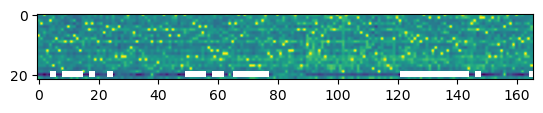

In [16]:
import numpy as np
def OneHotEncoding(sequence, amino_acids='ACDEFGHIKLMNPQRSTVWYX*'):

    seqlen = len(sequence)
    
    # Create a matrix of zeros with shape (len(sequence), len(amino_acids))
    one_hot_matrix = np.zeros((seqlen, len(amino_acids)), dtype='int')
    
    # Create a dictionary to map each amino acid to an index
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}
    
    # Fill in the one-hot matrix        
    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            one_hot_matrix[i, aa_to_index[aa]] =+ 1
        else:
            raise ValueError(f"Unknown amino acid: {aa}, from {sequence}")
    
    return one_hot_matrix

#Apply the One-Hot Encoding Function to the Series
one_hot_encoded = R1input.protseq.apply(lambda seq: OneHotEncoding(seq))
df = R1input
amino_acids = 'ACDEFGHIKLMNPQRSTVWYX*'
heatmap = np.zeros((len(df.protseq[0]),len(amino_acids)))
# Display the result
for i, matrix in enumerate(one_hot_encoded):
    heatmap = heatmap + matrix

print(heatmap / len(df.protseq) )
plt.imshow(np.log2(np.transpose(heatmap / len(df.protseq ))))

In [17]:
#TO DO
#compute enrichment scores for variants
#retrain a LLM on output
def findCommonVariants(df1,df2,nucleotide=True):
    k = set()
    if nucleotide:
        k = set(df1['variants']).intersection(set(df2['variants']))
        return [k,df1[df1['variants'].isin(k)], df2[df2['variants'].isin(k)]]
    else:
        k = set(df1['protseq']).intersection(set(df2['protseq']))
        return [df1[df1['protseq'].isin(k)], df2[df2['protseq'].isin(k)]]
    
    
[k,cR1inp,cR1primary] = findCommonVariants(filterByCounts(R1input,100),filterByCounts(R1primary,100))

In [18]:


# Function to compute coverage for a column
def compute_coverage(df1,df2,col):
    unique_values_df1 = set(df1[col].unique())
    unique_values_df2 = set(df2[col].unique())
    common_values = unique_values_df1.intersection(unique_values_df2)
    coverage = len(common_values) / len(unique_values_df1)
    return coverage

coverage = compute_coverage(filterByCounts(R1input,100,False),filterByCounts(R1primary,100,False),'protseq')
print(f'Coverage of column protseq: {coverage:.2%}')
coverage = compute_coverage(filterByCounts(R1input),filterByCounts(R1primary),'variants')
print(f'Coverage of column variants: {coverage:.2%}')
coverage = compute_coverage(filterByCounts(R1primary,100,False),filterByCounts(R1input,100,False),'protseq')
print(f'Coverage of column protseq: {coverage:.2%}')
coverage = compute_coverage(filterByCounts(R1primary),filterByCounts(R1input),'variants')
print(f'Coverage of column variants: {coverage:.2%}')

Coverage of column protseq: 82.45%
Coverage of column variants: 82.73%
Coverage of column protseq: 65.29%
Coverage of column variants: 50.82%


In [19]:


#compute log2 enrichments from dataframes
def getEnrichments(df1,df2,mincounts = 100,nucleotide=True):
    col = 'protseq'
    if nucleotide:
        col = 'variants'
        
    df1filt = filterByCounts(df1,mincounts,nucleotide)
    df2filt = filterByCounts(df2,mincounts,nucleotide)
    df1counts = df1filt[col].value_counts()
    df2counts = df2filt[col].value_counts()
    aligned1, aligned2 = df1counts.align(df2counts, 'outer',fill_value=1e-6)
    relative_frequencies = aligned2 / aligned1
    finite_mask = np.isfinite(relative_frequencies)
    filtered_freq = relative_frequencies[finite_mask]
    enrichments= np.log2(filtered_freq)
    return enrichments
    

In [20]:
len(getEnrichments(R1input,R1primary,100,True))

3180

In [21]:
enrichments1 = getEnrichments(R1input,R1primary,100,False)
enrichments2 = getEnrichments(R2input,R2primary,100,False)
r1align, r2align = enrichments1.align(enrichments2)

In [22]:

r1vsr2 = pd.DataFrame({'r1enrichments': r1align, 'r2enrichments':r2align})

len(r1vsr2)

3473

In [23]:
def removeNan(df):
    mask = np.isfinite(df) & df.notna() 
    filtered_df = df[mask.all(axis=1)]
    filtered_df = filtered_df[ (filtered_df > -20).all(axis=1) ] 
    filtered_df = filtered_df[ (filtered_df < 20).all(axis=1) ]
    return filtered_df

In [24]:
r1vsr2Filt = removeNan(r1vsr2)

In [26]:
r1vsr2Filt

,r1enrichments,r2enrichments
protseq,,
*KHQMLNLGYS*LNPMKGKA*ATFLAGSDVPTIYPQVDWVLWQELVL*WHVGKDFILILALVSKNWKRSHL**KWMLKG*PRCYRLLEWECSMSQFACVGLVMPSRLVTELNGSTSRCGSAIAINSRF*QSVQTVKHLLKCLRCGRMGAVTDVGCRLQKWQSYRRF,1.170014,0.412567
AEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,1.720477,1.968070
DRSTRC*TLAILD*TL*RGKPEPLSWQVQTCQPFIRKWIGYFGRNWCYSGTLGKISF*SSP*SARIGSDRICSRSGCSKVSPDVTACWSGNAA*ANSLVWGLLCRVALSPN*MAVQVGVEVRSPSTQDFSKVSKLSSTF*NACAVGGWVLSQM*DAVCRNGKATEG,0.679110,-0.190420
GEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,0.965892,1.503826
I*APDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,0.528496,-1.147644
...,...,...
REAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,1.037638,0.677327
RSTRC*TLAILD*TL*RGKPEPLSWQVQTCQPFIRKWIGYFGRNWCYSGTLGKISF*SSP*SARIGSDRICSRSGCSKVSPDVTACWSGNAA*ANSLVWGLLCRVALSPN*MAVQVGVEVRSPSTQDFSKVSKLSSTF*NACAVGGWVLSQM*DAVCRNGKATEGL,1.139930,0.165809
SEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,0.693573,0.692162


In [27]:
len(r1vsr2Filt)

1418

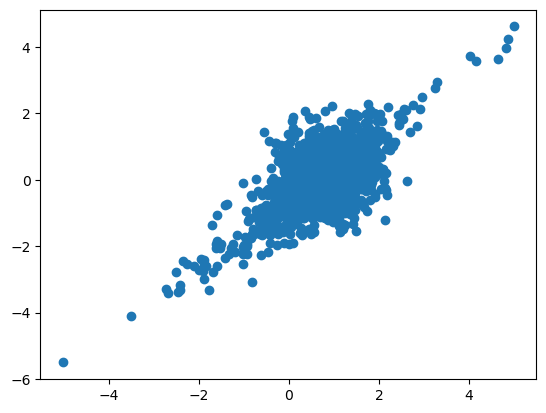

In [28]:
plt.scatter(r1vsr2Filt['r1enrichments'],r1vsr2Filt['r2enrichments'])

In [29]:
r1vsr2Filt['r1enrichments'].corr(r1vsr2Filt['r2enrichments'])

0.670745404576526

In [30]:
labels_with_asterisks = [idx for idx in r1vsr2Filt.index if '*'  in idx]
r1vsr2Filt2 = r1vsr2Filt.loc[labels_with_asterisks]

In [31]:
r1vsr2Filt2

,r1enrichments,r2enrichments
protseq,,
*KHQMLNLGYS*LNPMKGKA*ATFLAGSDVPTIYPQVDWVLWQELVL*WHVGKDFILILALVSKNWKRSHL**KWMLKG*PRCYRLLEWECSMSQFACVGLVMPSRLVTELNGSTSRCGSAIAINSRF*QSVQTVKHLLKCLRCGRMGAVTDVGCRLQKWQSYRRF,1.170014,0.412567
DRSTRC*TLAILD*TL*RGKPEPLSWQVQTCQPFIRKWIGYFGRNWCYSGTLGKISF*SSP*SARIGSDRICSRSGCSKVSPDVTACWSGNAA*ANSLVWGLLCRVALSPN*MAVQVGVEVRSPSTQDFSKVSKLSSTF*NACAVGGWVLSQM*DAVCRNGKATEG,0.679110,-0.190420
I*APDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,0.528496,-1.147644
IEAPDVKP*LFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,-0.404755,-1.220806
IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSAS*LGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,-0.502500,-1.264763
IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLA*IGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,0.286157,-0.783606
IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVAR*ERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,-0.434312,-1.353637
IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARW*RFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,0.409208,-0.584963
IEAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWE*FHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKV,0.441838,-0.047934


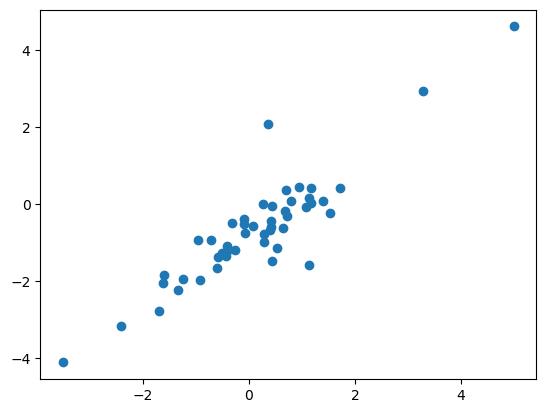

In [32]:
plt.scatter(r1vsr2Filt2['r1enrichments'],r1vsr2Filt2['r2enrichments'])

In [33]:
r1vsr2Filt2['r1enrichments'].corr(r1vsr2Filt2['r2enrichments'])

0.9009046661806089

In [34]:
len(r1vsr2Filt2)

48

In [35]:

def find_asterisk_index(s):
    if isinstance(s, str):  # Ensure the value is a string
        return s.find('*')
    else:
        return -1  # Return -1 if the value is not a string

# Apply the function to every element in the DataFrame
asterisk_indices = [find_asterisk_index(idx) for idx in r1vsr2Filt2.index]



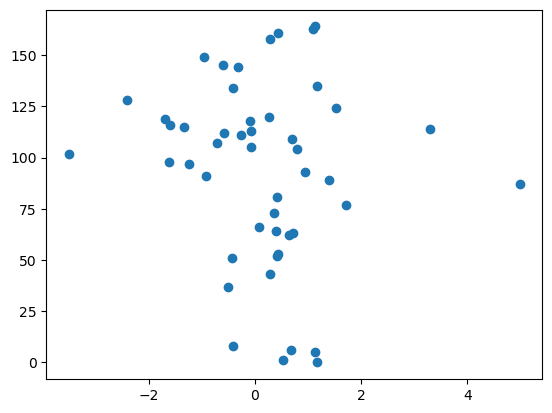

In [36]:
plt.scatter(r1vsr2Filt2['r1enrichments'],asterisk_indices)